In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size = 5
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,  batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([5, 3, 32, 32])
torch.Size([5])


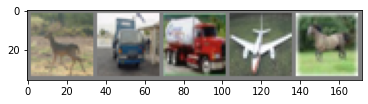

deer truck truck plane horse 


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
def print_class_labels(match_labels):
    class_labels = ""
    for i in range(batch_size):
        class_labels += f"{classes[match_labels[i]]} "
    print(class_labels)

print_class_labels(labels)

In [6]:
network_width = 16

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=network_width,kernel_size=3) # 3 input channels for colour image, 32 filters and a kernel size of 3 to avoid overfitting
        self.pool = nn.MaxPool2d(2) # Window of size 2 (where it takes the max from)
        self.conv2 = nn.Conv2d(in_channels=network_width,out_channels=network_width*2,kernel_size=3) # The input channels are now the output channels of the previous convolution, it's generally good practice to double the number of feature maps for every convolution layer.
        self.fc1 = nn.Linear(network_width * 2 * 6 * 6, 120)

        self.dropout1 = nn.Dropout(0.5) # Randomly zero some elements to prevent co-adaptaption of neurons (work independently)

        self.fc2 = nn.Linear(120, 10) # Reduce to 10 output nodes because there is 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
        x = self.fc2(x)
        return x

model = Model()
model

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

In [8]:
time0 = time()
epochs = 2
for e in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Zero the parameter gradients (otherwise PyTorch accumulates the gradients on subsequent backward passes)
        optimizer.zero_grad()

        # Forward Pass through the network
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Calculate the gradient
        loss.backward()

        # Update the weights
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{e + 1}, {i + 1}] loss: {running_loss / 2000}")
            running_loss = 0.0
print("\nTraining Time (in minutes) =",(time()-time0)/60)

[1, 2000] loss: 1.9209323539435863
[1, 4000] loss: 1.6122333078980446
[1, 6000] loss: 1.4929096672832967
[1, 8000] loss: 1.4451169475167989
[1, 10000] loss: 1.4007793230339884
[2, 2000] loss: 1.3491270346716047
[2, 4000] loss: 1.3215090634245426
[2, 6000] loss: 1.304446194626391
[2, 8000] loss: 1.3049342149011791
[2, 10000] loss: 1.2751848561763763

Training Time (in minutes) = 1.5345388491948446


In [9]:
torch.save(model, './my_cifar_model.pt')

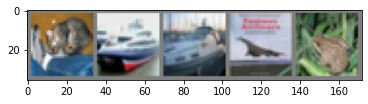

Ground Truth:
cat ship ship plane frog 
Predicted:
frog ship ship plane frog 


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth:")
print_class_labels(labels)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print("Predicted:")
print_class_labels(predicted)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10,000 test images {(correct / total) * 100}%")

Accuracy on 10,000 test images 51.21%


In [20]:
class_stats = {}
for output_class in classes:
    class_stats[output_class] = {
        correct: 0,
        total: 0
    }
# class_correct = list(0. for i in range(len(classes)))
# class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # Get a tensor of matched labels
        c = (predicted == labels)
        for i in range(batch_size):
            label = labels[i]
            if(c[i]):
                class_stats[label].correct += 1
            class_stats[label] += 1

print(class_stats)
# for output_class in classes:
#     print(f"Accuracy of {output_class}: {(output_class)}")
# for i in range(len(classes)):
#     print(f"Accuracy of {classes[i]}: {(class_stats[i] / class_total[i]) * 100:.2f}%")

KeyError: tensor(3)

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='my-dog.jpg', width=300, height=400)
display(pil_img)

In [ ]:
from PIL import Image


def image_loader(path_to_image):
    image = Image.open(path_to_image)
    resized = image.resize((32,32), Image.ANTIALIAS)
    resized.save(path_to_image.split('.')[0] + '-32x32.jpg')
    return transform(resized).unsqueeze(0)

my_dog_image = image_loader('my-dog.jpg')

from IPython.display import Image 
pil_img = Image(filename='my-dog-32x32.jpg')
display(pil_img)

output = model(my_dog_image)
prediction = int(torch.max(output.data, 1)[1].numpy())
print(f"Prediction: {classes[prediction]}")